# Evaluación de la pérdida de calidad del audio usando el codec OPUS

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 5 min read

---

## Resumen

La comunicación en la actualidad sería impensable sin el uso de codecs de audio digital para reducir el consumo del ancho de banda en las transmisiones de voz y música. Estos codecs utilizan algoritmos de compresión y limpieza del ruido para eliminar información del audio que el oído humano no escucha tan bien, para ello se utiliza un concepto llamado _bandas críticas_  y escala Bark (frecuencias bajas tienen mayor resolución que frecuencias bajas). Sin embargo, esta habilidad de compresión es precisamente una limitante para los sistemas de telemedicina que usan estetoscópios digitales, pues estos requieren analizar el audio sin pérdida de información. En este ipython notebook estudiamos la pérdida de la calidad del audio producida por el codec OPUS al analizar sonidos producidos por el corazón o los pulmones. Los resultados están aún por determinarse...

## Vistazo rápido al códec OPUS

Código abierto, frecuencia de muestreo de 8kHz a 48kHz, soporta voz y música [3]...

### Modos

Alternable entre SILK, CELT e híbrido [3].

* SILK para voz, códec creado por Skype Limited open-source y freeware basado en Codificación de Predicción Lineal [4, 5]. 
* Constrained Energy Lapped Transform (CELT) para música y voz de alta calidad, tomado de Ogg  
* E híbrido ...

### Psicoacústica

Transformada Discreta del Coseno Modificada (MDCT) y escala similar a Bark para enmascaramiento y preservación de la envolvente espectral. Ventana de análisis similar a la Hann o Hamming [3]...

### Rendimiento
Alta calidad desde el bitrate 8 kHz hasta 128 kHz [3]...

<img src='img/qualityOpus.png' width='50%'>
Figura 1. Tomada de https://opus-codec.org/static/comparison/quality.svg.


# Barrido de frecuencias

Para evaluar la distorción producida por el códec Opus, podemos usar un barrido de frecuencia de la forma [6]:
$$
F(t) = \Big(\frac{F_1-F_0}{T}\Big)t + F_0,
$$

para determinar cuales frecuencias han sido perdidas después del procesamiento. El rango de frecuencias a usar puede ser $[20, 22.5K]$ Hz (el rango conseguido comunmente con los equipos electrónicos comerciales). El barrido puede ser construido usando un senoidal de la forma $x[t] = A \sin(2\pi Ft)$.

Populating the interactive namespace from numpy and matplotlib


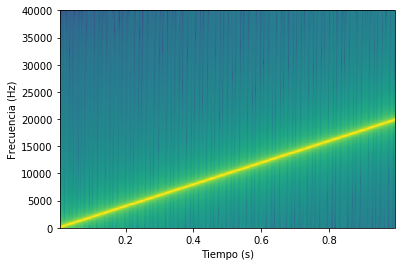

In [7]:
%pylab inline
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np

rango = [20.0, 20000.0] # el rango promedio de audicion humano en Hz
Fs = rango[1]*4 # 2 veces la freq. maxima para cumplir con el teorema del muestreo
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
x = np.sin(np.pi*F0/Fs*n) # f=F0/Fs (discrete frequency)

fig, ax = pylab.subplots(nrows=1)
ax.specgram(x, NFFT=1024, Fs=Fs, noverlap=900)
pylab.xlabel('Tiempo (s)')
pylab.ylabel('Frecuencia (Hz)')

wavfile.write('/tmp/barrido_20_20k.wav',int(Fs),x)
Audio(x, rate=Fs) 

# Codificacion mediante Opus

Ahora, realizamos el procesamiento con Opus usando, 128 Kbps, la tasa de bits más alta en la figura 1.

In [11]:
# s16le: signed 16-bit little-endian integer
!ffmpeg -loglevel error -y -qscale 0 -i /tmp/barrido_20_20k.wav /tmp/barrido_20_20k_2.wav # same quality
#!opusenc --quiet --bitrate 128 /tmp/barrido_20_20k_2.wav /tmp/opusEnc.opus
#!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

#fs, y = wavfile.read('/tmp/opusDec.wav')
#y = np.array(y)/max(y)

#fig, ax = pylab.subplots(nrows=1)
#ax.specgram(y, NFFT=1024, Fs=Fs, noverlap=900)
#pylab.xlabel('Tiempo (s)')
#pylab.ylabel('Frecuencia (Hz)')

#Audio(y, rate=fs)

Option qscale (use fixed quality scale (VBR)) cannot be applied to input url /tmp/barrido_20_20k.wav -- you are trying to apply an input option to an output file or vice versa. Move this option before the file it belongs to.
Error parsing options for input file /tmp/barrido_20_20k.wav.
Error opening input files: Invalid argument


Observamos que el contenido frecuencial de 20 a 20K Hz se mantiene, pero luego de 20kHz se ha perdido y antes de 20kHz muestra aliasing.

# Referencias
1. Colaboradores de Wikipedia. Códec de audio [en línea]. Wikipedia, La enciclopedia libre, 2020 [fecha de consulta: 4 de noviembre del 2020]. Disponible en <https://es.wikipedia.org/w/index.php?title=C%C3%B3dec_de_audio&oldid=129362034>. 
2. Hong  Kong  Polytechnic  University. Department of Electronic and Information Engineering. Perceptual Coding and MP3. Disponible en <http://www.eie.polyu.edu.hk/~enyhchan/DAP-lab-PModel-v3.pdf>.
3. López Monfort José Javier. Opus codec | 22/23 | UPV. Universitat Politècnica de València - UPV. Disponible en <https://youtu.be/2-yv1bCDL94>. 
4. Wikipedia contributors. (2020, October 11). SILK. In Wikipedia, The Free Encyclopedia. Retrieved 15:18, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=SILK&oldid=982904860
5. Wikipedia contributors. (2020, November 2). Linear predictive coding. In Wikipedia, The Free Encyclopedia. Retrieved 15:22, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=Linear_predictive_coding&oldid=986664067
6. EPFL. Room impulse responses. Ultima vez consultado el 27 Dec 2020 en: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = { Pruebas por pares o pairwise testing},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.pairwisetesting.html},
  urldate = {}
}
```